### Prelims

#### Imports

In [193]:
# Standard libraries
import os
from typing import Any, Sequence
import numpy as np

%load_ext tensorboard

# JAX/Equinox
import jax
import jax.numpy as jnp
from jax import random
import equinox as eqx

# PyTorch for data loading
import torch
import torch.utils.data as data

## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## equinox helper funcitons
from eqx_helpers import EqxTrainerModule, create_data_loaders

sns.reset_orig()
sns.set_theme()

DATASET_PATH = os.path.join(os.getcwd(), "data")
CHECKPOINT_PATH = os.path.join(os.getcwd(), "saved_models\\cifar_mess\\")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Load Data

In [194]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Transformations applied on each image => bring them into a numpy array
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])


def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255.0 - DATA_MEANS) / DATA_STD
    return img.transpose(2,0,1)


def img_restore(img):
    img = img.transpose(1,2,0)
    img = ((img * DATA_STD) + DATA_MEANS) * 255.0
    img = np.array(img, dtype=np.int32)
    return img

# augmentation step
test_transform = transforms.Compose(
    [   image_to_numpy,
    ]
)
train_transform = transforms.Compose(
    [   transforms.TrivialAugmentWide(),
        image_to_numpy,
    ]
)

# we don't want to augment the validation data, so we split this up
train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=train_transform, download=True
)
val_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=test_transform, download=True
) # note that we use `test_transform here`


# we split with the same seed, but using the transformed and untransformed data separately
train_set, _ = data.random_split(
    train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42)
)
_, val_set = data.random_split(
    val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42)
)

# Loading the test set
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=test_transform, download=True
)

#reducing the size of the data by 96% for testing:
_, train_set = data.random_split(
    train_set, [43200, 1800], generator=torch.Generator().manual_seed(42)
)

_, val_set = data.random_split(
    val_set, [4800, 200], generator=torch.Generator().manual_seed(42)
)
_, test_set = data.random_split(
    test_set, [9600, 400], generator=torch.Generator().manual_seed(42)
)



train_loader, val_loader, test_loader = create_data_loaders(
    train_set, val_set, test_set, train=[True, False, False], batch_size= 200 #256
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### CNN model

#### define model, blocks

In [170]:
class NormedConv_Block(eqx.Module):
    conv: eqx.nn.LayerNorm
    pool: eqx.nn.MaxPool2d
    drop: eqx.nn.Dropout
    batch_norm: eqx.nn.LayerNorm

    def __init__(
        self,
        input_shape: Sequence[int] = (3,32,32),
        out_channels: int = 16,
        conv_window: int = 3,
        pooling_kernel: int = 2,
        pooling_stride: int = 1,
        drop_rate: int = 0.0,
        key: jax.Array = random.key(42),
    ):
        """Block with the following layers:
        2D convolution -> 2D pooling -> RELU activation -> batch normalization

        Args:
            input_shape (Sequence[int], optional): Shape of (unbatched) input. Order is Channel, Height, Width. Defaults to (3,32,32).
            out_channels (int, optional): Number of output channels. Defaults to 16.
            conv_window (int, optional): Size of 2d convolutional window. Defaults to 3.
            pooling_kernel (int, optional): Kernel for 2d max pooling. Defaults to 2.
            pooling_stride (int, optional): Stride length for pooling. Defaults to 1.
            drop_rate (int, optional): Dropout rate. Defaults to 0.0.
            key (jax.Array, optional): PRNGKey. Defaults to random.key(42).
        """            
        self.conv = eqx.nn.Conv2d(
            input_shape[0], out_channels, kernel_size=conv_window, key=key
        )
        if pooling_kernel == pooling_stride == 1:
            self.pool = eqx.nn.Identity()
        else:
            self.pool = eqx.nn.MaxPool2d(pooling_kernel, stride=pooling_stride)
        self.drop = eqx.nn.Dropout(drop_rate)

        new_H = (
            int(((input_shape[1] - conv_window) + 1 - pooling_kernel) / pooling_stride)
            + 1
        )
        input_shape = (out_channels, new_H, new_H)
        self.batch_norm = eqx.nn.BatchNorm(out_channels, "batch", momentum=0.5)
        # self.batch_norm = eqx.nn.LayerNorm(input_shape[1:])

    def __call__(self, x, key, state, train=True):
        x = self.conv(x)
        x = self.pool(x)
        x = jax.nn.relu(x)
        x = self.drop(x, key=key, inference=not train)
        x, state = self.batch_norm(x, state, inference=not train)
        # x = jax.vmap(self.batch_norm)(x)
        return x, state


class NormedDense_Block(eqx.Module):
    dense: eqx.nn.Linear
    drop: eqx.nn.Dropout
    batch_norm: eqx.nn.BatchNorm

    def __init__(self, 
                 in_dim: int = 64, 
                 out_dim: int = 10, 
                 drop_rate: float = 0.0,
                 key: jax.Array = random.key(42)):
        """Block with the following layers:
        Linear NN -> RELU activation -> layer normalization

        Args:
            in_dim (int, optional): (Unbatched) input dimension. Defaults to 64.
            out_dim (int, optional): (Unbatched) output dimension. Defaults to 10.
            drop_rate (float, optional): Dropout rate. Defaults to 0.0.
            key (jax.Array, optional): PRNGKey. Defaults to random.key(42).
        """        
        self.dense = eqx.nn.Linear(in_dim, out_dim, key=key)
        self.drop = eqx.nn.Dropout(drop_rate)
        # self.batch_norm = eqx.nn.BatchNorm(out_dim, "batch")
        self.batch_norm = eqx.nn.LayerNorm(out_dim)

    def __call__(self, x, key, state, train=True):
        x = self.dense(x)
        x = jax.nn.relu(x)
        x = self.drop(x, key=key, inference=not train)
        # x, state = self.batch_norm(x, state, inference=not train)
        x = self.batch_norm(x)
        return x, state

In [171]:
class eqx_CNN_Classifier(eqx.Module):
    conv_layers: Sequence[NormedConv_Block]
    linear_layers: Sequence[NormedDense_Block]

    def __init__(
        self,
        input_shape: Sequence[int] = (3, 32, 32),
        num_classes: int = 10,
        conv_channels: Sequence[int] = [16],
        conv_windows: Sequence[int] = [5],
        pooling_kernel: Sequence[int] = [2],
        pooling_stride: Sequence[int] = [2],
        conv_drop: float = 0.0,
        hidden_dims: Sequence[int] = [64],
        dense_drop: float = 0.0,
        key: jax.Array = random.key(42),
    ):
        """Classifier formed by stacking convolutional and dense blocks.

        Args:
            input_shape (Sequence[int], optional): (Unbatched) shape of input. Order is Channel, Height, Width. Defaults to (3, 32, 32).
            num_classes (int, optional): Number of classes to predict. Shape of final dense output. Defaults to 10.
            conv_channels (Sequence[int], optional): Number of channels for each convolutional layer. Defaults to [16].
            conv_windows (Sequence[int], optional): Window size for each convolutional layer. Defaults to [5].
            pooling_kernel (Sequence[int], optional): Kernel size for each convolutional layer. Defaults to [2].
            pooling_stride (Sequence[int], optional): Stride length for each convolutional layer. Defaults to [2].
            conv_drop (float, optional): Dropout rate for convolutional layers. Defaults to 0.0.
            hidden_dims (Sequence[int], optional): Hidden dims for intermediate dense layers. Defaults to [64].
            dense_drop (float, optional): Dropout for dense layers. Defaults to 0.0.
            key (jax.Array, optional): PRNGKey. Defaults to random.key(42).
        """        
        def assert_equal_length(*sequences):
            # Calculate the lengths of all sequences
            lengths = [len(seq) for seq in sequences]

            # Check if all lengths are equal to the first length in the list
            assert all(
                length == lengths[0] for length in lengths
            ), f"Sequences defining ConvSA block are of different lengths: {lengths}"

        assert_equal_length(conv_channels, conv_windows, pooling_kernel, pooling_stride)
        
        # establish convulutional layers
        self.conv_layers = []
        key, *conv_keys = random.split(key, num=len(conv_channels) + 1)
        conv_iterator = enumerate(
            zip(conv_windows, conv_channels, pooling_kernel, pooling_stride, conv_keys)
        )
        for i, (cw, cf, pk, ps, k) in conv_iterator:
            self.conv_layers.append(
                NormedConv_Block(
                    input_shape=input_shape,
                    out_channels=cf,
                    conv_window=cw,
                    pooling_kernel=pk,
                    pooling_stride=ps,
                    key=k,
                    drop_rate=conv_drop,
                )
            )

            new_H = (
                int(
                    ((input_shape[1] - conv_windows[i]) + 1 - pooling_kernel[i])
                    / pooling_stride[i]
                )
                + 1
            )
            input_shape = (cf, new_H, new_H)

        # establish linear layers
        self.linear_layers = []
        key, *lin_keys = random.split(key, num=len(hidden_dims) + 1)
        input_shape = np.prod(input_shape)
        for i, (hidden_dim, k) in enumerate(zip(hidden_dims, lin_keys)):
            self.linear_layers.append(
                NormedDense_Block(
                    in_dim=input_shape, out_dim=hidden_dim, key=k, drop_rate=dense_drop
                )
            )
            input_shape = hidden_dim
        self.linear_layers.append(
            NormedDense_Block(
                in_dim=input_shape, out_dim=num_classes, key=key, drop_rate=0
            )
        )

    def __call__(self, x, key, state, train=True):
        subkey, *conv_keys = random.split(key, num=len(self.conv_layers) + 1)
        for layer, k in zip(self.conv_layers, conv_keys):
            x, state = layer(x, k, state=state, train=train)
        x = jnp.ravel(x)
        subkey, *lin_keys = random.split(subkey, num=len(self.linear_layers) + 1)
        for layer, k in zip(self.linear_layers, lin_keys):
            x, state = layer(x, k, state=state, train=train)
        x = jax.nn.log_softmax(x)
        return x, state

#### Set up trainer

In [172]:
import optuna


class CNNClassTrainer(EqxTrainerModule):
    def __init__(
        self,
        conv_windows: Sequence[int],
        conv_channels: Sequence[int],
        pooling_kernel: Sequence[bool],
        pooling_stride: Sequence[bool],
        hidden_dims: Sequence[int],
        input_shape: int,
        num_classes: int,
        conv_drop: float = 0.0,
        dense_drop: float = 0.0,
        trial: Any = None,
        **kwargs,
    ):
        self.trial = trial
        super().__init__(
            model_class=eqx_CNN_Classifier,
            model_hparams={
                "conv_windows": conv_windows,
                "conv_channels": conv_channels,
                "pooling_kernel": pooling_kernel,
                "pooling_stride": pooling_stride,
                "input_shape": input_shape,
                "hidden_dims": hidden_dims,
                "num_classes": num_classes,
                "conv_drop": conv_drop,
                "dense_drop": dense_drop,
            },
            **kwargs,
        )

    def create_functions(self):
        def loss_function(model, x, y, key, state, train=True):
            model_out, state = jax.vmap(
                model,
                axis_name="batch",
                in_axes=(0, None, None, None),
                out_axes=(0, None),
            )(x, key, state, train)
            # since we use log_softmax, cross entropy is just the value of our model output
            # indexed by the true value of y.
            loss = jnp.take_along_axis(model_out, jnp.expand_dims(y, 1), axis=1)
            loss = -jnp.mean(loss)

            pred_y = jnp.argmax(model_out, axis=1)
            acc = jnp.mean(y == pred_y)
            return loss, (acc, state)

        def train_step(model, opt_state, batch, key, state):
            x, y = batch
            (loss, (acc, state)), grads = eqx.filter_value_and_grad(
                loss_function, has_aux=True
            )(model, x, y, key, state)
            updates, opt_state = self.opt.update(grads, opt_state, model)
            model = eqx.apply_updates(model, updates)
            metrics = {"loss": loss, "acc": acc}
            return model, opt_state, metrics, state

        def eval_step(model, batch, key, state):
            x, y = batch
            _, (acc, _) = loss_function(model, x, y, key, state, train=False)
            return {"acc": acc}

        return train_step, eval_step

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics["val/acc"], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    def bind_model(self):
        """
        Returns a batched model with parameters bound to it. Enables an easier inference
        access.

        Returns:
          The model with `key`, `state`, `train`, baked in, such that it only takes x input
        """

        def mod(x):
            model_out, state = jax.vmap(
                self.model,
                axis_name="batch",
                in_axes=(0, None, None, None),
                out_axes=(0, None),
            )(x, self.key, self.state, False)
            return model_out

        return mod

    def vizualize_grad_norms(self, batch):
        """Plots histogram of gradient norms of model leaves
            interior functiosn are 75% copy-paste from `create_functions`
        """

        def loss_function(model, x, y, key, state, train=True):
            model_out, state = jax.vmap(
                model,
                axis_name="batch",
                in_axes=(0, None, None, None),
                out_axes=(0, None),
            )(x, key, state, train)
            # since we use log_softmax, cross entropy is just the value of our model output
            # indexed by the true value of y.
            loss = jnp.take_along_axis(model_out, jnp.expand_dims(y, 1), axis=1)
            loss = -jnp.mean(loss)

            pred_y = jnp.argmax(model_out, axis=1)
            acc = jnp.mean(y == pred_y)
            return loss, (acc, state)

        def get_grad_and_path(model, batch, key, state):
            x, y = batch
            (loss, (acc, state)), grads = eqx.filter_value_and_grad(
                loss_function, has_aux=True
            )(model, x, y, key, state)
            dt = jax.tree_util.tree_leaves_with_path(grads)
            grads, names = [], []
            for (
                path,
                grad,
            ) in (
                dt
            ):  # filter basic info we don't care about (bias terms, normalization)
                if (
                    (len(grad.shape) > 1)
                    and (path[-1].name != "bias")
                    and (not path[-2].name.endswith("norm"))
                ):
                    grads.append(grad.reshape(-1))
                    names.append(path[-2].name + "_" + path[-1].name)
            return grads, names

        def viz_grads(grads, names, color="C0"):
            columns = len(grads)
            fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
            for g_idx, g in enumerate(grads):
                key = f"{names[g_idx]}"
                key_ax = ax[g_idx % columns]
                sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
                key_ax.set_title(str(key))
                key_ax.set_xlabel("Grad magnitude")
            fig.suptitle("Gradient magnitude distributions", fontsize=14, y=1.05)
            fig.subplots_adjust(wspace=0.45)
            plt.show()
            plt.close()

        grads, names = get_grad_and_path(self.model, batch, self.key, self.state)
        viz_grads(grads, names)

In [173]:
trainer = CNNClassTrainer(
    conv_windows=[3, 5],
    conv_channels=[16, 32],
    pooling_kernel=[2, 2],
    pooling_stride=[2, 2],
    hidden_dims=[64],
    input_shape=(3, 32, 32),
    num_classes=10,
    conv_drop=0.0,
    dense_drop=0.25,
    optimizer_hparams={"optimizer": "nadamw", "lr": 5e-3},
    logger_params={
        "base_log_dir": CHECKPOINT_PATH, # model params, checkpointed models, and TensorBoard events files go here 
    },
    check_val_every_n_epoch=5, # this means the model is checkpointed every fifth epoch
    seed=42,
    debug=False,
)


#### Train Model

In [174]:
metrics = trainer.train_model(train_loader, val_loader, test_loader, 5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

#### Model Evaluation

In [175]:
print(f'Validation accuracy: {metrics["val/acc"]:4.2%}')
print(f'Test accuracy: {metrics["test/acc"]:4.2%}')

Validation accuracy: 39.50%
Test accuracy: 40.50%


In [176]:
trainer.log_dir

'c:\\Users\\austin\\Desktop\\Research\\random\\saved_models\\cifar_mess\\eqx_CNN_Classifier\\version_0'

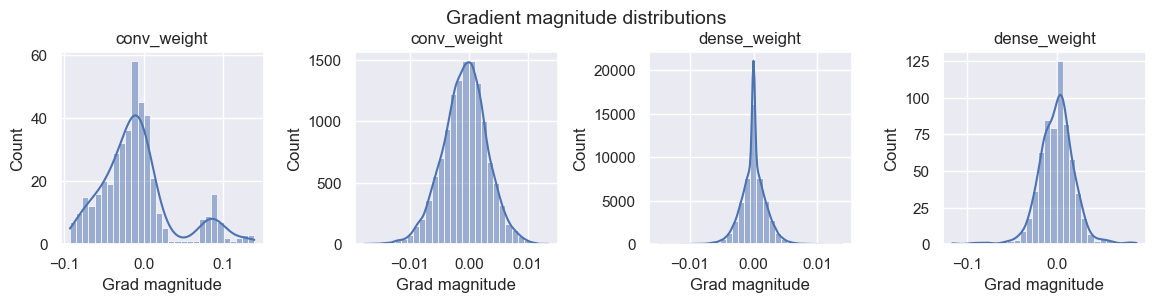

In [177]:
batch = next(iter(train_loader))
trainer.vizualize_grad_norms(batch) # I didn't jit this funciton so it takes a bit

# some suspicious distributions. do we need to change out activations/initializations?

In [178]:
# confirm loading checkpoints works properly!

imgs, y = batch
mod = trainer.bind_model()

trainer2 = CNNClassTrainer.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, r'eqx_CNN_Classifier\\version_0') )
mod2 = trainer2.bind_model()

pred = mod(imgs).argmax(-1) # our model ends with log-softmax
pred2 = mod2(imgs).argmax(-1)

assert jnp.all(pred2 == pred)

In [179]:
print((pred != y).mean())
misclass_imgs = imgs[pred != y]
bad_pred = pred[pred != y]
real_answer = y[pred != y]

labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

0.66999996


predicted: horse
real: deer


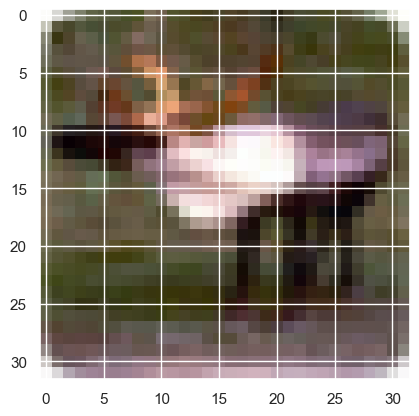

In [181]:
i = 2
print(f"predicted: {labels[bad_pred[i]]}")
print(f"real: {labels[real_answer[i]]}")
plt.imshow(img_restore(misclass_imgs[i]))

### CNN with attention

#### define blocks, model

In [182]:
class NormedConvSA_Block(eqx.Module):
    conv: eqx.nn.Conv2d
    pool: eqx.nn.MaxPool2d
    drop: eqx.nn.Dropout
    batch_norm1: eqx.nn.BatchNorm
    batch_norm2: eqx.nn.BatchNorm
    attention: eqx.nn.MultiheadAttention
    input_shape: tuple

    def __init__(
        self,
        input_shape: Sequence[int] = (3, 32, 32),
        out_channels: int = 16,
        conv_window: int = 3,
        pooling_kernel: int = 2,
        pooling_stride: int = 1,
        drop_rate: int = 0.0,
        key: jax.Array = random.key(42),
    ):
        """Block with the following layers:
        2D convolution -> 2D pooling -> RELU activation -> batch norm -> self-attention -> batch norm

        Args:
            input_shape (Sequence[int], optional): Shape of (unbatched) input. Order is Channel, Height, Width. Defaults to (3,32,32).
            out_channels (int, optional): Number of output channels. Defaults to 16.
            conv_window (int, optional): Size of 2d convolutional window. Defaults to 3.
            pooling_kernel (int, optional): Kernel for 2d max pooling. Defaults to 2.
            pooling_stride (int, optional): Stride length for pooling. Defaults to 1.
            drop_rate (int, optional): Dropout rate. Defaults to 0.0.
            key (jax.Array, optional): PRNGKey. Defaults to random.key(42).
        """          
        key1, key2 = random.split(key)
        self.conv = eqx.nn.Conv2d(
            input_shape[0], out_channels, kernel_size=conv_window, key=key1
        )
        if pooling_kernel == pooling_stride == 1:
            self.pool = eqx.nn.Identity()
        else:
            self.pool = eqx.nn.MaxPool2d(pooling_kernel, stride=pooling_stride)
        self.drop = eqx.nn.Dropout(drop_rate)

        new_H = (
            int(((input_shape[1] - conv_window) + 1 - pooling_kernel) / pooling_stride)
            + 1
        )
        self.input_shape = (out_channels, new_H, new_H)
        self.batch_norm1 = eqx.nn.BatchNorm(out_channels, "batch", momentum=0.5)
        self.batch_norm2 = eqx.nn.BatchNorm(out_channels, "batch", momentum=0.5)
        # self.batch_norm1 = eqx.nn.LayerNorm(self.input_shape[1:])
        # self.batch_norm2 = eqx.nn.LayerNorm(self.input_shape[1:])

        self.attention = eqx.nn.MultiheadAttention(
            1, new_H**2, key=key2, dropout_p=drop_rate
        )

    def __call__(self, x, key: jax.Array, state=None, train=True):
        key1, key2 = random.split(key)
        x = self.conv(x)
        x = self.pool(x)
        x = jax.nn.relu(x)
        x = self.drop(x, key=key1, inference=not train)
        x, state = self.batch_norm1(x, state, inference=not train)
        # x = jax.vmap(self.batch_norm1)(x)
        x_q = jnp.reshape(
            x, (self.input_shape[0], self.input_shape[1] * self.input_shape[2])
        )
        attn = self.attention(x_q, x_q, x_q, key=key2, inference=not train)
        attn = jnp.reshape(
            attn, (self.input_shape[0], self.input_shape[1], self.input_shape[2])
        )
        # x = jax.vmap(self.batch_norm2)(x + attn)
        x, state = self.batch_norm2(x+attn, state, inference=not train)
        return x, state


In [183]:
class eqx_CNN_SA_Classifier(eqx.Module):
    conv_layers: Sequence[NormedConvSA_Block]
    linear_layers: Sequence[NormedDense_Block]

    def __init__(
        self,
        input_shape: Sequence[int] = (3, 32, 32),
        num_classes: int = 10,
        conv_channels: Sequence[int] = [16],
        conv_windows: Sequence[int] = [5],
        pooling_kernel: Sequence[int] = [2],
        pooling_stride: Sequence[int] = [2],
        conv_drop: float = 0.0,
        hidden_dims: Sequence[int] = [64],
        dense_drop: float = 0.0,
        key: jax.Array = random.key(42),
    ):
        """Classifier formed by stacking convolutional+self attention and dense blocks.

    Args:
        input_shape (Sequence[int], optional): (Unbatched) shape of input. Order is Channel, Height, Width. Defaults to (3, 32, 32).
        num_classes (int, optional): Number of classes to predict. Shape of final dense output. Defaults to 10.
        conv_channels (Sequence[int], optional): Number of channels for each convolutional layer. Defaults to [16].
        conv_windows (Sequence[int], optional): Window size for each convolutional layer. Defaults to [5].
        pooling_kernel (Sequence[int], optional): Kernel size for each convolutional layer. Defaults to [2].
        pooling_stride (Sequence[int], optional): Stride length for each convolutional layer. Defaults to [2].
        conv_drop (float, optional): Dropout rate for convolutional layers. Defaults to 0.0.
        hidden_dims (Sequence[int], optional): Hidden dims for intermediate dense layers. Defaults to [64].
        dense_drop (float, optional): Dropout for dense layers. Defaults to 0.0.
        key (jax.Array, optional): PRNGKey. Defaults to random.key(42).
        """        
        def assert_equal_length(*sequences):
            # Calculate the lengths of all sequences
            lengths = [len(seq) for seq in sequences]

            # Check if all lengths are equal to the first length in the list
            assert all(
                length == lengths[0] for length in lengths
            ), f"Sequences defining ConvSA block are of different lengths: {lengths}"

        assert_equal_length(conv_channels, conv_windows, pooling_kernel, pooling_stride)

        # establish convulutional layers
        self.conv_layers = []
        key, *conv_keys = random.split(key, num=len(conv_channels) + 1)
        conv_iterator = enumerate(
            zip(conv_windows, conv_channels, pooling_kernel, pooling_stride, conv_keys)
        )
        for i, (cw, cf, pk, ps, k) in conv_iterator:
            self.conv_layers.append(
                NormedConvSA_Block(
                    input_shape=input_shape,
                    out_channels=cf,
                    conv_window=cw,
                    pooling_kernel=pk,
                    pooling_stride=ps,
                    key=k,
                    drop_rate=conv_drop,
                )
            )

            # necessary to track input shapes for each layer, follows basic convolution shape formula
            new_H = (
                int(
                    ((input_shape[1] - conv_windows[i]) + 1 - pooling_kernel[i])
                    / pooling_stride[i]
                )
                + 1
            )
            input_shape = (cf, new_H, new_H)

        # establish linear layers
        self.linear_layers = []
        key, *lin_keys = random.split(key, num=len(hidden_dims) + 1)
        input_shape = np.prod(input_shape)
        for i, (hidden_dim, k) in enumerate(zip(hidden_dims, lin_keys)):
            self.linear_layers.append(
                NormedDense_Block(
                    in_dim=input_shape, out_dim=hidden_dim, key=k, drop_rate=dense_drop
                )
            )
            input_shape = hidden_dim
        self.linear_layers.append(
            NormedDense_Block(
                in_dim=input_shape, out_dim=num_classes, key=key, drop_rate=0
            )
        )

    @eqx.filter_jit
    def __call__(self, x, key, state=None, train=True):
        subkey, *conv_keys = random.split(key, num=len(self.conv_layers) + 1)
        for layer, k in zip(self.conv_layers, conv_keys):
            x, state = layer(x, k, state=state, train=train)
        x = jnp.ravel(x)
        subkey, *lin_keys = random.split(subkey, num=len(self.linear_layers) + 1)
        for layer, k in zip(self.linear_layers, lin_keys):
            x, state = layer(x, k, state=state, train=train)
        x = jax.nn.log_softmax(x)
        return x, state


#### Set up trainer

In [184]:
import optuna


class CNN_SAClassTrainer(EqxTrainerModule):
    def __init__(
        self,
        conv_windows: Sequence[int],
        conv_channels: Sequence[int],
        pooling_kernel: Sequence[bool],
        pooling_stride: Sequence[bool],
        hidden_dims: Sequence[int],
        input_shape: int,
        num_classes: int,
        conv_drop: float = 0.0,
        dense_drop: float = 0.0,
        trial: Any = None,
        **kwargs,
    ):
        self.trial = trial
        super().__init__(
            model_class=eqx_CNN_SA_Classifier,
            model_hparams={
                "conv_windows": conv_windows,
                "conv_channels": conv_channels,
                "pooling_kernel": pooling_kernel,
                "pooling_stride": pooling_stride,
                "input_shape": input_shape,
                "hidden_dims": hidden_dims,
                "num_classes": num_classes,
                "conv_drop": conv_drop,
                "dense_drop": dense_drop,
            },
            **kwargs,
        )

    def create_functions(self):
        def loss_function(model, x, y, key, state, train=True):
            model_out, state = jax.vmap(
                model,
                axis_name="batch",
                in_axes=(0, None, None, None),
                out_axes=(0, None),
            )(x, key, state, train)
            # since we use log_softmax, cross entropy is just the value of our model output
            # indexed by the true value of y.
            loss = jnp.take_along_axis(model_out, jnp.expand_dims(y, 1), axis=1)
            loss = -jnp.mean(loss)

            pred_y = jnp.argmax(model_out, axis=1)
            acc = jnp.mean(y == pred_y)
            return loss, (acc, state)

        def train_step(model, opt_state, batch, key, state):
            x, y = batch
            (loss, (acc, state)), grads = eqx.filter_value_and_grad(
                loss_function, has_aux=True
            )(model, x, y, key, state)
            updates, opt_state = self.opt.update(grads, opt_state, model)
            model = eqx.apply_updates(model, updates)
            metrics = {"loss": loss, "acc": acc}
            return model, opt_state, metrics, state

        def eval_step(model, batch, key, state):
            x, y = batch
            _, (acc, _) = loss_function(model, x, y, key, state, train=False)
            return {"acc": acc}

        return train_step, eval_step

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics["val/acc"], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    def bind_model(self):
        """
        Returns a batched model with parameters bound to it. Enables an easier inference
        access.

        Returns:
          The model with parameters and evt. batch statistics bound to it.
        """

        def mod(x):
            model_out, state = jax.vmap(
                self.model,
                axis_name="batch",
                in_axes=(0, None, None, None),
                out_axes=(0, None),
            )(x, self.key, self.state, False)
            return model_out

        return mod

    def vizualize_grad_norms(self, batch):
        """Plots histogram of gradient norms of model leaves"""

        def loss_function(model, x, y, key, state, train=True):
            model_out, state = jax.vmap(
                model,
                axis_name="batch",
                in_axes=(0, None, None, None),
                out_axes=(0, None),
            )(x, key, state, train)
            # since we use log_softmax, cross entropy is just the value of our model output
            # indexed by the true value of y.
            loss = jnp.take_along_axis(model_out, jnp.expand_dims(y, 1), axis=1)
            loss = -jnp.mean(loss)

            pred_y = jnp.argmax(model_out, axis=1)
            acc = jnp.mean(y == pred_y)
            return loss, (acc, state)

        def get_grad_and_path(model, batch, key, state):
            x, y = batch
            (loss, (acc, state)), grads = eqx.filter_value_and_grad(
                loss_function, has_aux=True
            )(model, x, y, key, state)
            dt = jax.tree_util.tree_leaves_with_path(grads)
            grads, names = [], []
            for (
                path,
                grad,
            ) in (
                dt
            ):  # filter basic info we don't care about (bias terms, normalization)
                if (
                    (len(grad.shape) > 1)
                    and (path[-1].name != "bias")
                    and (not path[-2].name.endswith("norm"))
                ):
                    grads.append(grad.reshape(-1))
                    names.append(path[-2].name + "_" + path[-1].name)
            return grads, names

        def viz_grads(grads, names, color="C0"):
            columns = len(grads)
            fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
            for g_idx, g in enumerate(grads):
                key = f"{names[g_idx]}"
                key_ax = ax[g_idx % columns]
                sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
                key_ax.set_title(str(key))
                key_ax.set_xlabel("Grad magnitude")
            fig.suptitle("Gradient magnitude distributions", fontsize=14, y=1.05)
            fig.subplots_adjust(wspace=0.45)
            plt.show()
            plt.close()

        grads, names = get_grad_and_path(self.model, batch, self.key, self.state)
        viz_grads(grads, names)


#### train model

In [185]:
trainer2 = CNN_SAClassTrainer(
    conv_windows=[5],
    conv_channels=[16],
    pooling_kernel=[2],
    pooling_stride=[2],
    hidden_dims=[64],
    input_shape=(3, 32, 32),
    num_classes=10,
    conv_drop=0.0,
    dense_drop=0.25,
    optimizer_hparams={"optimizer": "nadamw", "lr": 5e-3},
    logger_params={
        "base_log_dir": CHECKPOINT_PATH,
    },
    check_val_every_n_epoch=5,
    seed=42,
    debug=False,
)


In [186]:
metrics2 = trainer2.train_model(train_loader, val_loader, test_loader, 5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

#### model evaluation

In [188]:
print(f'Validation accuracy: {metrics2["val/acc"]:4.2%}')
print(f'Test accuracy: {metrics2["test/acc"]:4.2%}')

Validation accuracy: 28.00%
Test accuracy: 31.75%


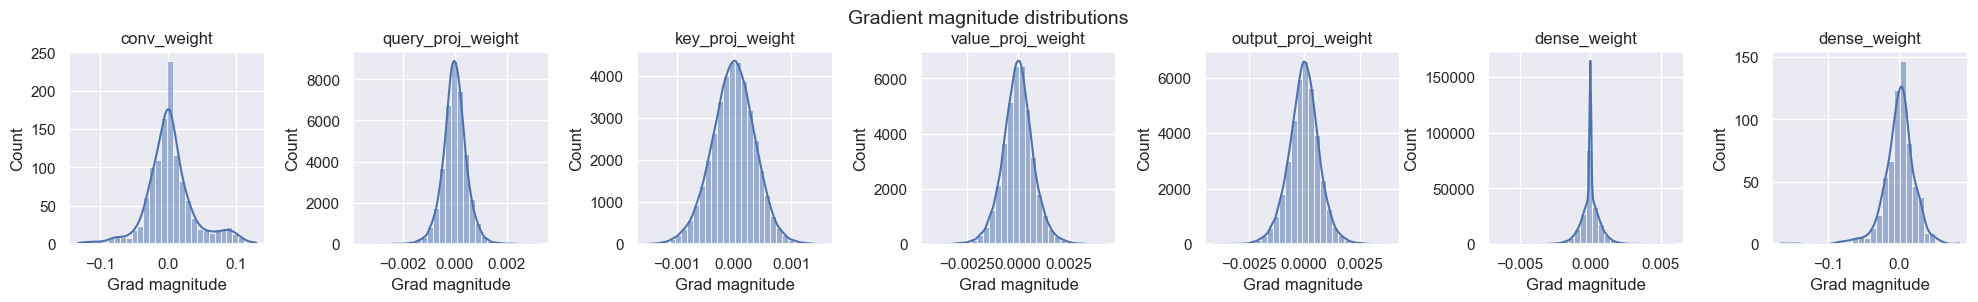

In [189]:
batch = next(iter(train_loader))
trainer2.vizualize_grad_norms(batch)


### optuna hyperparam val example

In [190]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loaders(
        train_set, val_set, train=[True, False], batch_size=200
    )
    trainer = CNNClassTrainer(
        conv_windows=[3, 5],
        conv_channels=[16, 32],
        pooling_kernel=[2, 2],
        pooling_stride=[2, 2],
        hidden_dims=[64],
        input_shape=(3, 32, 32),
        num_classes=10,
        conv_drop=0.0,
        dense_drop=trial.suggest_float("drop", 0.1, 0.6, log=True),
        optimizer_hparams={
            "optimizer": "nadamw",
            "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True),
            "lr": trial.suggest_float("lr", 1e-5, 5e-2, log=True),
        },
        logger_params={"base_log_dir": CHECKPOINT_PATH},
        check_val_every_n_epoch=5,
        trial=trial,
    )
    metrics = trainer.train_model(my_train_loader, my_val_loader, num_epochs=25)
    del trainer
    del my_train_loader, my_val_loader
    return metrics["val/acc"]

In [191]:
study = optuna.create_study(
    study_name="mlp_cifar10",
    storage=f'sqlite:///{os.path.join(CHECKPOINT_PATH, trainer.config["model_class"] ,"optuna_hparam_search_eqn.db")}',
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10),
    load_if_exists=True,
)
study.optimize(objective, n_trials=25 - len(study.trials), n_jobs=1)

[I 2024-07-04 11:58:45,702] A new study created in RDB with name: mlp_cifar10


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 11:59:39,636] Trial 0 finished with value: 0.33000001311302185 and parameters: {'drop': 0.5519691394957986, 'weight_decay': 0.07128254592201888, 'lr': 5.8505099396434635e-05}. Best is trial 0 with value: 0.33000001311302185.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:00:36,163] Trial 1 finished with value: 0.41499999165534973 and parameters: {'drop': 0.19739726076654704, 'weight_decay': 0.018428213667987064, 'lr': 0.00019092902008723998}. Best is trial 1 with value: 0.41499999165534973.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:01:30,876] Trial 2 finished with value: 0.26499998569488525 and parameters: {'drop': 0.13794508798772398, 'weight_decay': 0.0011216392284551248, 'lr': 2.5611282405505576e-05}. Best is trial 1 with value: 0.41499999165534973.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:02:26,125] Trial 3 finished with value: 0.48500001430511475 and parameters: {'drop': 0.16945083436576378, 'weight_decay': 0.0004625004079101799, 'lr': 0.0005546741491099429}. Best is trial 3 with value: 0.48500001430511475.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:03:23,063] Trial 4 finished with value: 0.19999998807907104 and parameters: {'drop': 0.17507598503381308, 'weight_decay': 0.059805398223474256, 'lr': 1.0440650743837625e-05}. Best is trial 3 with value: 0.48500001430511475.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:03:48,061] Trial 5 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:04:47,129] Trial 6 finished with value: 0.5249999761581421 and parameters: {'drop': 0.28053154396735563, 'weight_decay': 0.0007543022655780234, 'lr': 0.01052212768242797}. Best is trial 6 with value: 0.5249999761581421.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:05:43,756] Trial 7 finished with value: 0.5 and parameters: {'drop': 0.10412045004462582, 'weight_decay': 3.719891809511638e-05, 'lr': 0.001622198732503443}. Best is trial 6 with value: 0.5249999761581421.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:06:39,595] Trial 8 finished with value: 0.4399999976158142 and parameters: {'drop': 0.41087329051450167, 'weight_decay': 0.0003179387764512751, 'lr': 0.022978682122811234}. Best is trial 6 with value: 0.5249999761581421.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:07:34,526] Trial 9 finished with value: 0.5299999713897705 and parameters: {'drop': 0.1605772374127113, 'weight_decay': 1.3105066897093324e-05, 'lr': 0.008896639100810481}. Best is trial 9 with value: 0.5299999713897705.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:08:29,507] Trial 10 finished with value: 0.5349999666213989 and parameters: {'drop': 0.27400708959504155, 'weight_decay': 1.0301587031377691e-05, 'lr': 0.004291981635112356}. Best is trial 10 with value: 0.5349999666213989.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:09:28,838] Trial 11 finished with value: 0.4650000035762787 and parameters: {'drop': 0.28291601933528393, 'weight_decay': 1.2360417404745713e-05, 'lr': 0.005253997290748795}. Best is trial 10 with value: 0.5349999666213989.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:10:25,719] Trial 12 finished with value: 0.4949999749660492 and parameters: {'drop': 0.24403518356332785, 'weight_decay': 5.3825555518602365e-05, 'lr': 0.0033370176409364435}. Best is trial 10 with value: 0.5349999666213989.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:10:49,976] Trial 13 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:11:45,579] Trial 14 finished with value: 0.5 and parameters: {'drop': 0.22535773798159306, 'weight_decay': 0.00011871333672275946, 'lr': 0.0008384081250023965}. Best is trial 10 with value: 0.5349999666213989.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:12:40,200] Trial 15 finished with value: 0.4899999499320984 and parameters: {'drop': 0.11870830896954543, 'weight_decay': 0.006687438779979216, 'lr': 0.00617160960430692}. Best is trial 10 with value: 0.5349999666213989.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:13:03,685] Trial 16 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:13:38,377] Trial 17 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:14:06,062] Trial 18 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:14:33,802] Trial 19 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:15:32,655] Trial 20 finished with value: 0.5399999618530273 and parameters: {'drop': 0.12952073921735716, 'weight_decay': 0.00012564636958146277, 'lr': 0.002425155279208925}. Best is trial 20 with value: 0.5399999618530273.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:16:28,436] Trial 21 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:17:24,630] Trial 22 finished with value: 0.4949999749660492 and parameters: {'drop': 0.10031174620851219, 'weight_decay': 3.310817977146432e-05, 'lr': 0.010362374766982327}. Best is trial 20 with value: 0.5399999618530273.


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:17:49,053] Trial 23 pruned. 


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-07-04 12:18:24,192] Trial 24 pruned. 


In [192]:
trial = study.best_trial
print(f"Best Validation Accuracy: {trial.value:4.2%}")
print(f"Best Params:")
for key, value in trial.params.items():
    print(f"-> {key}: {value}")

fig = optuna.visualization.plot_intermediate_values(study)
fig.show()
fig = optuna.visualization.plot_param_importances(study)
fig.show()
fig = optuna.visualization.plot_contour(study, params=["lr", "weight_decay"])
fig.show()

Best Validation Accuracy: 54.00%
Best Params:
-> drop: 0.12952073921735716
-> weight_decay: 0.00012564636958146277
-> lr: 0.002425155279208925
